# Unitary cost function gradient descent

Created 27/09/2024

Objectives:
* Apply gradient descent algorithm to an MPO to see wether it converges to some unitary.

# Package imports

In [1]:
import sys

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import re

# Load data

In [6]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [7]:
f_name = DATA_DIR + r"/0_90.h5"

In [8]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_90.h5'

In [9]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [10]:
NUM_SITES=5
BOND_DIMENSION=4
PHYSICAL_DIMENSION=2
LEARNING_RATE = 0.01

In [11]:
total_dimension = PHYSICAL_DIMENSION**NUM_SITES

In [12]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [13]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

In [14]:
def generate_random_w_tensor(dims):
    x1 = np.random.rand(*dims)
    x2 = 1j*np.random.rand(*dims)

    return x1 + x2

In [15]:
edge_dims = [PHYSICAL_DIMENSION,]*2 + [BOND_DIMENSION,]
inner_dims = edge_dims + [BOND_DIMENSION,]

In [16]:
w = generate_random_w_tensor(edge_dims)

In [17]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [18]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [19]:
w_tensors = [w_tensor,]

In [20]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [21]:
w = generate_random_w_tensor(edge_dims)

In [22]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [23]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [24]:
w_tensors.append(w_tensor)

In [25]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

## Functions

In [26]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [27]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [28]:
def order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [29]:
def order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

## Rescale tensor

In [30]:
mpo_frobenius_inner_product(w_tensors)

(2729455.2352270307+0j)

In [31]:
scale_factor = np.power(
    mpo_frobenius_inner_product(w_tensors).real,
    -1/(2*NUM_SITES)
)

In [32]:
scale_factor

0.2271916692203614

In [33]:
for w in w_tensors:
    w *= scale_factor

In [34]:
mpo_frobenius_inner_product(w_tensors)

(0.9999999999999987+2.7755575615628914e-17j)

## Sweep function

In [35]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    leg_labels = raw_mpo_tensor.get_leg_labels()

    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [36]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     score_list,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]]):
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    score_list.append(score.real)

In [37]:
def unitary_mpo_gradient_descent_sweep(mpo_tensors, learning_rate):
    # Initialise variables
    right_two_tensors = order_two_right_tensors(mpo_tensors)
    right_four_tensors = order_four_right_tensors(mpo_tensors)

    left_two_tensors = list()
    left_four_tensors = list()

    order_two_scores = list()
    order_four_scores = list()

    num_sites = len(mpo_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    t = right_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    update_mpo_score(grad_2, w, order_two_scores, [['vL*',], ['vR*',]])

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    update_mpo_score(grad_4, w, order_four_scores, [['vL1*',], ['vR*',]])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    # Update tensor
    mpo_tensors[0] = w + learning_rate*(grad_2 - grad_4)

    # Create and save left tensors
    w = mpo_tensors[0]

    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_four_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w=mpo_tensors[i]
        right_two_tensor = right_two_tensors[i]
        right_four_tensor = right_four_tensors[i]

        # Order two terms
        left_two_tensor = left_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        update_mpo_score(grad_2, w, order_two_scores)
        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )
        
        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        update_mpo_score(grad_4, w, order_four_scores, [['vL1*', 'vR1*',], ['vR*', 'vL*',]])
        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        mpo_tensors[i] = w + learning_rate*(grad_2 - grad_4)

        w = mpo_tensors[i]

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_four_tensors.append(t)

    # Last site
    left_two_tensor = left_two_tensors[-1]
    w = mpo_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    
    update_mpo_score(grad_2, w, order_two_scores, [['vR*',], ['vL*',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])
    
    update_mpo_score(grad_4, w, order_four_scores, [['vR1*',], ['vL*',]])
    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    mpo_tensors[-1] = w + learning_rate*(grad_2 - grad_4)

    return (order_two_scores, order_four_scores)

In [38]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [39]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

# Analysis

## Learning rates

### Initialize tensors

In [40]:
w = generate_random_w_tensor(edge_dims)

In [41]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [42]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [43]:
w_tensors = [w_tensor,]

In [44]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [45]:
w = generate_random_w_tensor(edge_dims)

In [46]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [47]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [48]:
w_tensors.append(w_tensor)

In [49]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [50]:
mpo_frobenius_inner_product(w_tensors)

(1799127.092464555+5.820766091346741e-11j)

In [51]:
scale_factor = np.power(
    mpo_frobenius_inner_product(w_tensors).real,
    -1/(2*NUM_SITES)
)

In [52]:
scale_factor

0.2368611402533671

In [53]:
for w in w_tensors:
    w *= scale_factor

In [54]:
mpo_frobenius_inner_product(w_tensors)

(0.9999999999999996-2.7755575615628914e-17j)

### Gradient descent

In [55]:
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
num_iterations = 500
unitarity_errors = list()

In [56]:
for lr in learning_rates:
    w_tensors_current = [w.copy() for w in w_tensors]
    unitarity_errors.append(list())

    for _ in range(num_iterations):
        o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors_current, lr)

        unitarity_errors[-1].append(
            unitarity_errors_from_subscores(o2, o4, total_dimension)
        )

In [57]:
flattened_errors = np.array(unitarity_errors).reshape(len(learning_rates), -1)

In [58]:
flattened_errors.shape

(10, 2500)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21706/3134303450.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


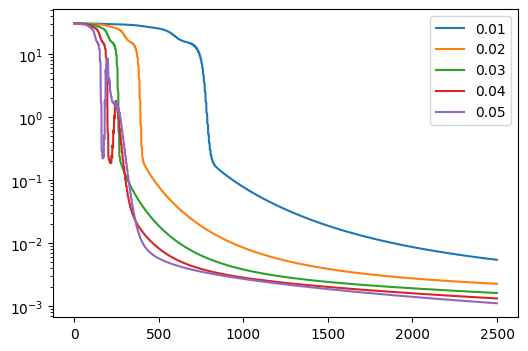

In [59]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(5):
    ax.plot(flattened_errors[i], label=learning_rates[i])

ax.set_yscale('log')
ax.legend()

fig.show()

# Conclusions
* It works!
* Will need to tune learning rate case by case, not as straight forward as non-mpo case.
    * Extra analysis could be useful to figure out the optimal learning rate with respect to bond dimension and number of sites, etc.
* Initialization of the mpos is important to prevent divergence.